In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [12]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size= BATCH_SIZE,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
   
)

Found 2153 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

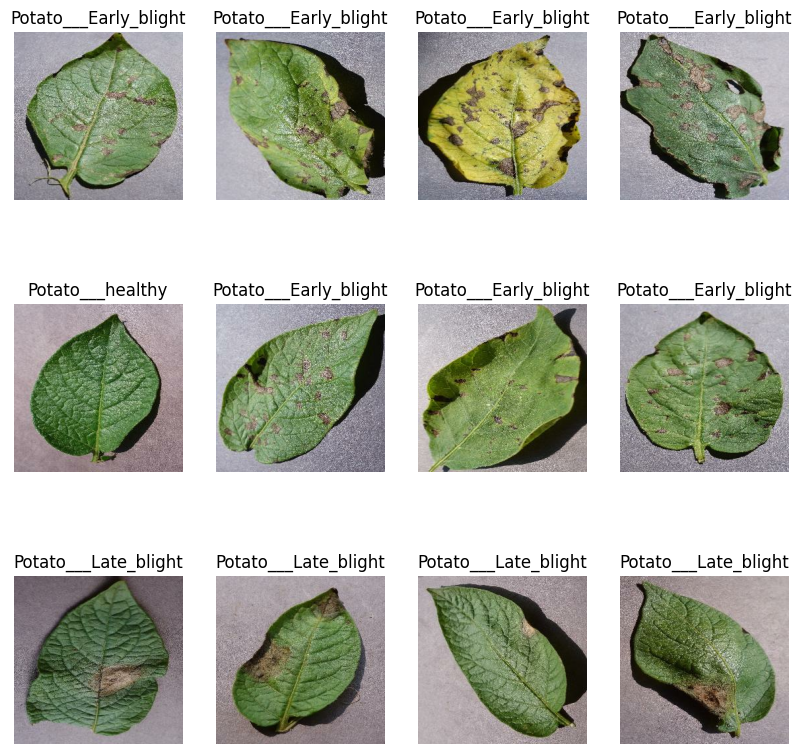

In [85]:
plt.figure(figsize= (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):   
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
     
    # print(image_batch[0].shape)
    # print(label_batch.numpy())

In [31]:
len(dataset)

68

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [32]:
train_size = 0.8
len(dataset)* train_size

54.400000000000006

In [34]:
train_ds = dataset.take(54)
len(train_ds)

54

In [67]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True,shuffle_size = 10000):

    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed =12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)    
       

    return train_ds,val_ds,test_ds

In [68]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [69]:
len(train_ds)

54

In [70]:
len(val_ds)

6

In [72]:
len(test_ds)

8

In [75]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it



In [82]:
# Resizing and Rescaling Layer
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Removed experimental
    tf.keras.layers.Rescaling(1./255),                # Removed experimental
])



In [83]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Removed experimental
    tf.keras.layers.RandomRotation(0.2),                   # Removed experimental
])

## CNN

In [99]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    ## A convolutional layer that scans the image with a 3x3 filter to detect features (e.g., edges of disease spots). Starts with 32 filters.
    ##kernel_size=(3,3)The filter size (3x3 pixels).activation='relu' An activation function that adds non-linearity, helping the model learn complex patterns (think of it as adding flavor to distinguish features).
    ##input_shape: Specifies the input shape (should be (256, 256, 3) for a single image, not including BATCH_SIZE—more on this below).
    layers.MaxPooling2D((2, 2)), ##Reduces the image size by taking the max value in 2x2 areas, like summarizing details to focus on key patterns, making the model faster and less prone to overfitting.
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),##Increases the number of filters (to 64) and repeats the process, letting the model learn more complex features at different scales.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),##: Flattens the 2D image data into a 1D array, like unrolling a map into a list, to feed into the final layers.
    layers.Dense(64, activation='relu'),##A fully connected layer with 64 neurons, combining features for decision-making.
    layers.Dense(n_classes, activation='softmax'),##The output layer with 3 neurons (one per class), using softmax to assign probabilities (e.g., 70% Early Blight, 20% Late Blight, 10% Healthy).
])

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [113]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
11/54 ━━━━━━━━━━━━━━━━━━━━ 32s 761ms/step - accuracy: 0.9914 - loss: 0.0476

KeyboardInterrupt: 

In [103]:

scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.9854 - loss: 0.0888


In [104]:
scores

[0.11055020242929459, 0.984375]

In [105]:
history


In [106]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [107]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [109]:
history.history['accuracy']

[0.5318287014961243,
 0.6961805820465088,
 0.8287037014961243,
 0.8773148059844971,
 0.8900462985038757,
 0.9172453880310059,
 0.9172453880310059,
 0.9432870149612427,
 0.9560185074806213,
 0.9456018805503845,
 0.9618055820465088,
 0.9421296119689941,
 0.9612268805503845,
 0.96875,
 0.9699074029922485,
 0.9675925970077515,
 0.9791666865348816,
 0.96875,
 0.9716435074806213,
 0.9670138955116272,
 0.9756944179534912,
 0.9878472089767456,
 0.9722222089767456,
 0.9722222089767456,
 0.9901620149612427,
 0.9820601940155029,
 0.9866898059844971,
 0.9855324029922485,
 0.9641203880310059,
 0.9837962985038757,
 0.9722222089767456,
 0.9872685074806213,
 0.9918981194496155,
 0.9901620149612427,
 0.9849537014961243,
 0.9901620149612427,
 0.9936342835426331,
 0.9635416865348816,
 0.9890046119689941,
 0.9791666865348816,
 0.9814814925193787,
 0.9791666865348816,
 0.9884259104728699,
 0.9953703880310059,
 0.9953703880310059,
 0.9947916865348816,
 0.9918981194496155,
 0.9890046119689941,
 0.99016201496

In [119]:
EPOCHS = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

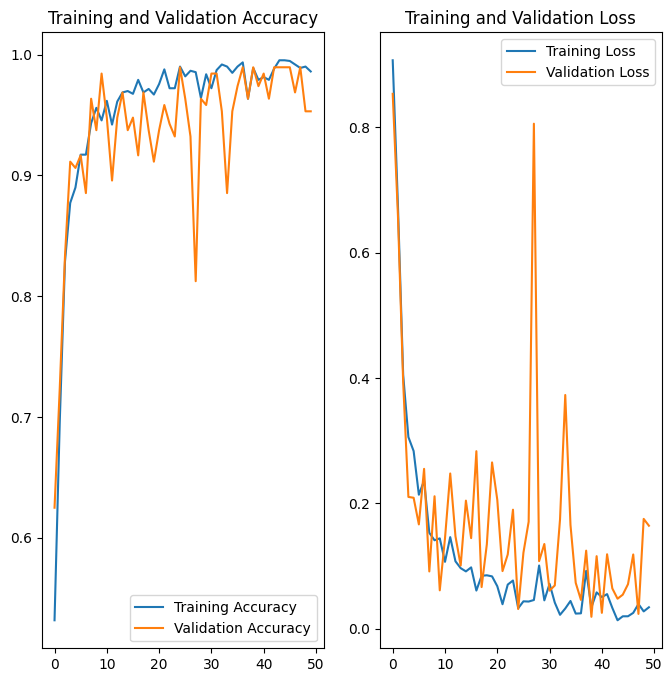

In [120]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
predicted label: Potato___Early_blight


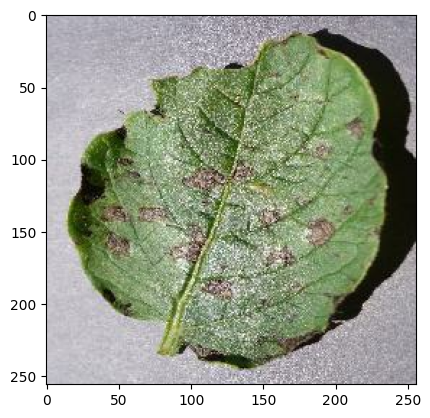

In [121]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [122]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


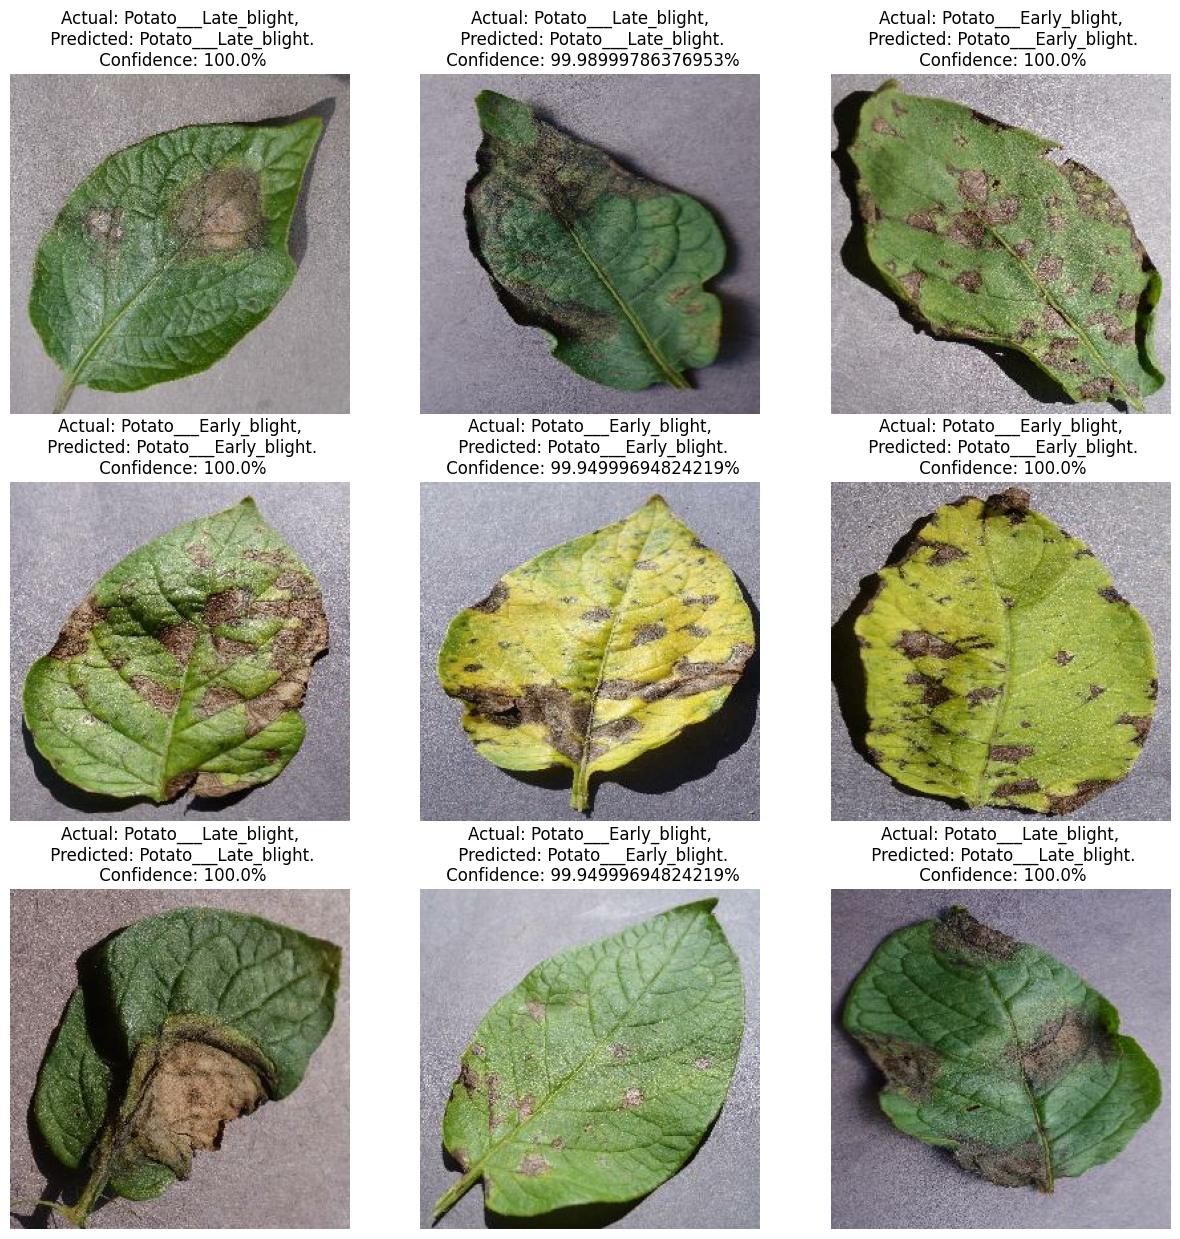

In [123]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [125]:
model_version = 1
model.save(f"../models/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/1.

In [129]:
import os
os.makedirs("../models", exist_ok=True)  # Creates the folder if it doesn’t exist

In [130]:
model_version = 1
model.save(f"../models/{model_version}.keras")

In [131]:
import os
os.listdir("../models")

['1.keras']

In [133]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

ValueError: invalid literal for int() with base 10: '1.keras'

In [134]:
import os

# Get the highest version number from existing .keras files
versions = [int(f.split('.')[0]) for f in os.listdir("../models") if f.endswith('.keras')] + [0]
model_version = max(versions) + 1

# Save the model with the new version
model.save(f"../saved_models/{model_version}.keras")